2.1 데이터 정리

먼저 데이터를 로드하고 결측값을 처리하며 필요 없는 열을 제거합니다.

결측치 처리 전과 후 데이터 수를 비교하여 결측지가 1개 있었음을 확인.

In [1]:
import pandas as pd
import numpy as np

# 데이터 로드
file_path = './wine_review.csv'
wine_data = pd.read_csv(file_path)

initial_review_count = wine_data.shape[0]

# 리뷰열에서 결측값 처리
wine_data = wine_data.dropna(subset=['reviews.text'])

# 전처리 작업 후 리뷰 데이터의 수
processed_review_count = wine_data.shape[0]

print(f"처리 이전 리뷰 데이터 수: {initial_review_count}건")
print(f"처리 이후 리뷰 데이터 수: {processed_review_count}건")

처리 이전 리뷰 데이터 수: 2890건
처리 이후 리뷰 데이터 수: 2889건


2.2 텍스트 토큰화 및 불용어 제거

NLTK 라이브러리를 사용하여 텍스트 데이터를 토큰화

분석에 방해가 되는 노이즈(불용어, 특수 문자, 숫자)를 제거합니다.


In [6]:
%pip install nltk 
import re # 정규 표현식 라이브러리
import nltk # 자연어 처리 라이브러리
from nltk.corpus import stopwords # 불용어 리스트 제공 모듈
from nltk.tokenize import word_tokenize # 단어 토큰화 모듈
from sklearn.model_selection import train_test_split, cross_val_score # 데이터 분할 및 교차 검증 모듈
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc  # 모델 평가 모듈
nltk.download('vader_lexicon')  # VADER 감정 분석기에 필요한 어휘 자료
nltk.download('punkt') # 토큰화를 위한 데이터
nltk.download('stopwords') # 불용어 리스트

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 특수 문자 제거
    text = re.sub(r'\W', ' ', text)
    # 숫자 제거
    text = re.sub(r'\d', ' ', text)
    # 단어 토큰화
    tokens = word_tokenize(text)
    # 불용어 제거 및 알파벳 문자인 단어만 남기기
    tokens = [word for word in tokens if word.isalpha() and word.lower() not in stop_words]
    # 각 토큰을 스테밍하여 어간 추출
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    # 스테밍된 토큰들을 공백으로 결합하여 반환
    return ' '.join(stemmed_tokens)

# 리뷰 텍스트에 전처리 함수 적용
wine_data['processed_text'] = wine_data['reviews.text'].apply(preprocess_text)

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# 전처리 전후의 단어 수 비교 함수
def compare_word_counts(row):
    original_text = row['reviews.text']
    processed_text = row['processed_text']
    
    original_word_count = len(word_tokenize(original_text))
    processed_word_count = len(word_tokenize(processed_text))
    
    return original_word_count, processed_word_count

# 샘플 데이터에 적용하여 결과 확인
sample_data = wine_data.head(10).apply(compare_word_counts, axis=1)
sample_data = pd.DataFrame(sample_data.tolist(), columns=['original_word_count', 'processed_word_count'])

print(sample_data)

# 전체 데이터셋에 대한 평균 단어 수 비교
average_original_word_count = wine_data['reviews.text'].apply(lambda x: len(word_tokenize(x))).mean()
average_processed_word_count = wine_data['processed_text'].apply(lambda x: len(word_tokenize(x))).mean()

print(f"처리 이전 평균 단어 수: {average_original_word_count:.2f}")
print(f"처리 이후 평균 단어 수: {average_processed_word_count:.2f}")

   original_word_count  processed_word_count
0                    9                     4
1                   10                     4
2                   29                    10
3                   11                     5
4                   76                    29
5                   47                    19
6                   26                    11
7                   82                    35
8                    4                     2
9                   28                    14
처리 이전 평균 단어 수: 39.13
처리 이후 평균 단어 수: 17.29


2.3 텍스트 정규화 (스테밍 또는 표제어 추출)

NLTK의 PorterStemmer를 사용하여 텍스트를 정규화합니다.

In [8]:
# 샘플 결과 확인
print(wine_data[['reviews.text', 'processed_text']].head())

                                        reviews.text  \
0      This a fantastic white wine for any occasion!   
1   Tart, not sweet...very refreshing and delicious!   
2  I was given this wine so it was a delightful s...   
3  This is a phenomenal wine and my new favorite ...   
4  4 750ml bottles for the price of two With way ...   

                                      processed_text  
0                           fantast white wine occas  
1                          tart sweet refresh delici  
2  given wine delight surpris find flavor delici ...  
3                      phenomen wine new favorit red  
4  ml bottl price two way less packag ye pleas ne...  


3. 모델 선택 및 학습

3.1 모델 선택

NLTK의 VADER 감정 분석기를 사용하여 감성 분석을 수행합니다.

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# VADER 감정 분석기 초기화
sia = SentimentIntensityAnalyzer()

# 감성 분석 함수 정의
def analyze_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

wine_data['sentiment'] = wine_data['processed_text'].apply(analyze_sentiment)

3.2 데이터셋 분할

데이터를 학습 세트와 테스트 세트로 분할합니다.

In [10]:
from sklearn.model_selection import train_test_split

# 학습 세트와 테스트 세트로 분할
train_data, test_data = train_test_split(wine_data, test_size=0.2, random_state=42)

4. 모델 평가

4.1 평가 지표

모델의 성능을 정확도, 정밀도, 재현율, F1 점수 및 ROC-AUC와 같은 지표를 사용하여 평가합니다.

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# 테스트 데이터에 대한 예측
test_data['predicted_sentiment'] = test_data['processed_text'].apply(analyze_sentiment)

# 평가 지표 계산
print(classification_report(test_data['sentiment'], test_data['predicted_sentiment']))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        47
     neutral       1.00      1.00      1.00        88
    positive       1.00      1.00      1.00       443

    accuracy                           1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578



5. 시각화 및 해석

5.1 혼동 행렬 및 ROC 곡선

Matplotlib를 사용하여 혼동 행렬과 ROC 곡선을 시각화합니다.

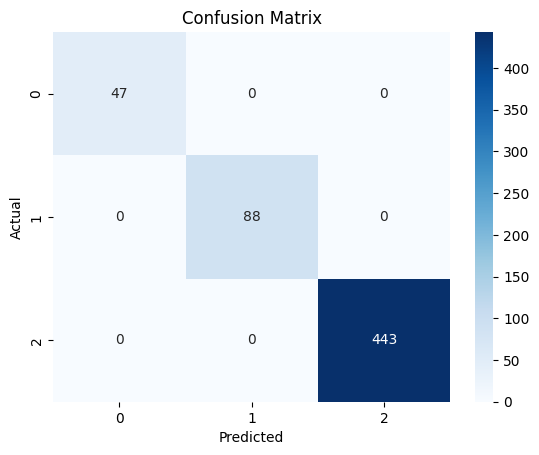

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 혼동 행렬 생성
conf_matrix = confusion_matrix(test_data['sentiment'], test_data['predicted_sentiment'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [13]:
# ROC 곡선 및 AUC 계산
y_true = test_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
y_scores = test_data['processed_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

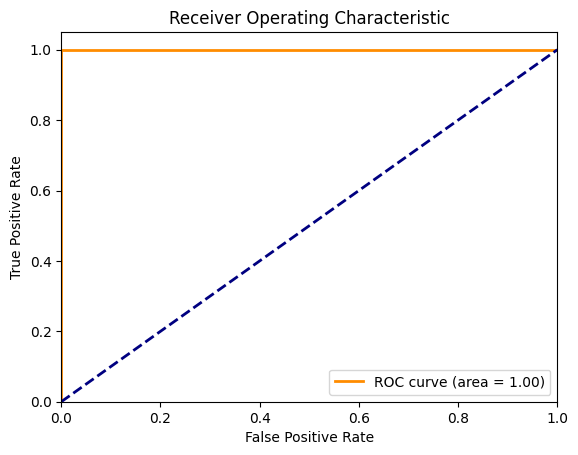

In [14]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()